<a href="https://colab.research.google.com/github/Ignacioelamo/LLMs4Phishing/blob/main/02_Extracci%C3%B3n_caracter%C3%ADsticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extracción de las características del cuerpo del correo:
1. **body_html=contains_html**: This is a binary feature that represents the presence of HTML in the email body.  
2. **body_forms**: This binary feature represents the presence of forms in HTML email bodies.
3. **body_noWords**: This feature measures the total number of words occurring in the email.
4.  **body_noCharacters**: This feature measures the total number of characters occurring in the email body.
5.  **body_noDistinctWords**: This feature measures the total number of distinct words occurring in the body of the email.  
6. **body_richness**: The richness is defined as the ratio of the number of words to the number of characters in the document.
$$
\text{body_richness} = \frac{\text{body_noWords}}{\text{body_noCharacters}}
$$
8. **body_noFunctionWords** Chandrasekaran [6] also listed a set of function words that included:  
`account`, `access`, `bank`, `credit`, `click`, `identity`, `inconvenience`, `information`, `limited`, `log`, `minutes`, `password`, `recently`, `risk`, `social`, `security`, `service`, and `suspended`.  The `body_noFunctionWords` feature measures the total number of occurrences of these function words in the email body.
9. **body_suspension** This binary feature represents the presence of the word **"suspension"** in the body of the email.  
10.  **body_verifyYourAccount** This binary feature represents the presence of the phrase **"verify your account"** in the body of the email.
11. **body_text** contains information regarding the context and purpose of an email. For this, we extract the plain text from the email body and use word embedding techniques to represent it.

Añadimos las features que ya teníamos: has_attachment, contains_html, urls.

In [ ]:
#Es necesario la version de numpy= 1.26.4
#%pip install --upgrade --force-reinstall numpy==1.26.4 pandas

In [ ]:
NOMBRE_ARCHIVO = 'emails.csv'

!wget https://raw.githubusercontent.com/Ignacioelamo/LLMs4Phishing/main/data/01_combined_cleaned_email_data.csv -O $NOMBRE_ARCHIVO

--2025-05-23 10:07:30--  https://raw.githubusercontent.com/Ignacioelamo/LLMs4Phishing/main/data/01_combined_cleaned_email_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10034933 (9.6M) [text/plain]
Saving to: ‘emails.csv’

emails.csv          100%[===================>]   9.57M  --.-KB/s    in 0.07s   

2025-05-23 10:07:31 (140 MB/s) - ‘emails.csv’ saved [10034933/10034933]



In [ ]:
import pandas as pd
df = pd.read_csv(NOMBRE_ARCHIVO)

In [ ]:
df.columns

Index(['source', 'subject', 'body', 'contains_html', 'has_attachment', 'urls',
       'label'],
      dtype='object')

In [ ]:
def extract_body_features(df):
    # Feature 3: body_noWords (Total number of words)
    df['body_noWords'] = df['body'].apply(lambda x: len(str(x).split()))

    # Feature 4: body_noCharacters (Total number of characters)
    df['body_noCharacters'] = df['body'].apply(lambda x: len(str(x)))

    # Feature 5: body_noDistinctWords (Total number of distinct words)
    df['body_noDistinctWords'] = df['body'].apply(lambda x: len(set(str(x).split())))

    # Feature 6: body_richness (Ratio of words to characters)
    df['body_richness'] = df['body_noWords'] / df['body_noCharacters']

    # Feature 7: body_noFunctionWords (Count of specific function words)
    function_words = [
        'account', 'access', 'bank', 'credit', 'click', 'identity', 'inconvenience',
        'information', 'limited', 'log', 'minutes', 'password', 'recently', 'risk',
        'social', 'security', 'service', 'suspended',
    ]
    df['body_noFunctionWords'] = df['body'].apply(lambda x: sum(1 for word in str(x).split() if word.lower() in function_words))

    return df
df = extract_body_features(df)

In [ ]:
#Usamos el model MiniLM-L6-v2 para generar la feature del body_text
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
df =df.dropna(subset=['body'])
emails=df['body'].tolist()
embeddings = model.encode(emails, show_progress_bar=True)
df["body_text"]=embeddings.tolist()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Para sacar los tópicos de los correos podemos hacerlo de dos formas:
1. BERTopic: usa embeddings contextuales para agrupar documentos, y luego re-pondera con TF-IDF para extraer términos.
2. LDA: modelo generativo de tópicos sobre Bag-of-Words, que descubre distribuciones de palabras.

In [ ]:
%pip install --upgrade --force-reinstall gensim pyLDAvis

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached pyLDAvis-3.4.1-py3-none-any.whl.metadata (4.2 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached joblib-1.5.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached numexpr-2.10.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.1 kB)
  Using cached funcy-2.0-py2.py3-none-any.whl.metadata (5.9 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached setuptools-80.8.0-py3-none-an

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [ ]:
#Lematizamos el body del correo para aplicar el modelo LDA
import spacy
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.11/dist-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/usr/local/lib/python3.11/dist-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


El Coherence Score es una medida de qué tan “coherentes” aparecen los tópicos para la interpretación, basándose en la co-ocurrencia de las palabras más representativas dentro de los documentos. Nos dice cuanto de interpretables son los tópicos. Obtenemos un valor moderado.

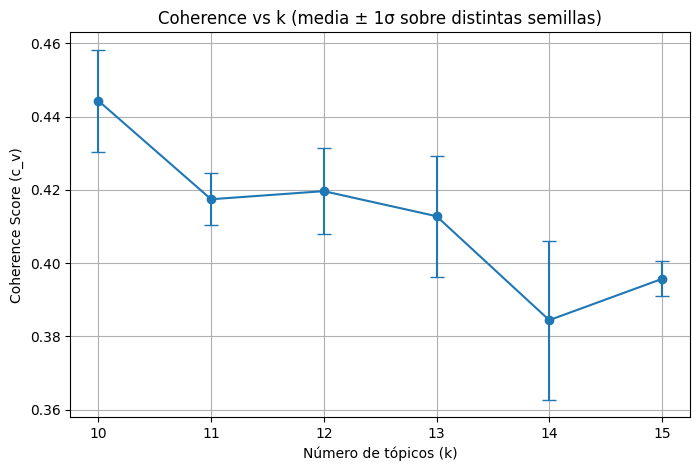

In [ ]:
#MODELO LDA:
texts = df['body'].astype(str).tolist()

# 2) Prepara stopwords y spaCy para lematizar (igual que en el notebook)
nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])
stop_words = set(stopwords.words('english'))

def lemmatize_tokens(doc):
    parsed = nlp(doc)
    return [
        token.lemma_.lower()
        for token in parsed
        if token.lemma_ not in stop_words
           and token.is_alpha
           and len(token.lemma_) > 3
    ]

data_lemm = [lemmatize_tokens(doc) for doc in texts]

# 3) Detecta bigramas y aplícalos
bigram = Phrases(data_lemm, min_count=5, threshold=100)
bigram_mod = Phraser(bigram)
data_words = [bigram_mod[doc] for doc in data_lemm]

# 4) Crea el diccionario y el corpus de Gensim (Bag-of-Words)
id2word = corpora.Dictionary(data_words)
id2word.filter_extremes(no_below=15, no_above=0.5)
corpus = [id2word.doc2bow(text) for text in data_words]

# --- Promedio de coherencia sobre varias corridas ---
k_values = list(range(10, 16))
seeds    = [0, 7, 42, 99, 123]   # distintas semillas
results  = {k: [] for k in k_values}

for k in k_values:
    for seed in seeds:
        lda = LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=k,
            random_state=seed,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto'
        )
        cm = CoherenceModel(
            model=lda,
            texts=data_words,
            dictionary=id2word,
            coherence='c_v'
        )
        results[k].append(cm.get_coherence())

# --- Calcular media y desviación ---
means = [np.mean(results[k]) for k in k_values]
stds  = [np.std(results[k])  for k in k_values]

# --- Graficar con barras de error ---
plt.figure(figsize=(8,5))
plt.errorbar(k_values, means, yerr=stds, fmt='-o', capsize=5)
plt.xticks(k_values)
plt.xlabel("Número de tópicos (k)")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence vs k (media ± 1σ sobre distintas semillas)")
plt.grid(True)
plt.show()

En el k=10 obtenemos el óptimo para el número de tópicos, ya que es el que alcanza el mayor valor medio tiene y la desviación que puede producir al tomar diferentes semillas es baja.

In [ ]:
#Por lo que usamos k=10 para el modelo LDA
lda = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=10,
    random_state=42,
    chunksize=100,
    passes=10,
    alpha='auto',
    eta='auto',
    per_word_topics=True
)

# 6) Imprime los términos más representativos de cada tópico
for idx, topic in lda.print_topics(num_topics=10, num_words=10):
    print(f"Tópico {idx:2d}: {topic}")

#Graficamos los topicos usando pyLDAvis
data = gensimvis.prepare(lda, corpus, id2word)
pyLDAvis.display(data)

Tópico  0: 0.022*"claim" + 0.018*"security" + 0.015*"thank" + 0.015*"bank" + 0.014*"make" + 0.014*"well" + 0.013*"know" + 0.012*"time" + 0.012*"need" + 0.011*"want"
Tópico  1: 0.064*"verification" + 0.034*"wait" + 0.027*"action" + 0.025*"collection" + 0.023*"care" + 0.023*"month" + 0.021*"group" + 0.020*"name" + 0.018*"cashback" + 0.017*"storage"
Tópico  2: 0.044*"free" + 0.039*"offer" + 0.031*"money" + 0.023*"good" + 0.023*"detail" + 0.021*"opportunity" + 0.021*"today" + 0.019*"year" + 0.019*"investment" + 0.018*"every"
Tópico  3: 0.160*"user" + 0.140*"microsoft" + 0.053*"device" + 0.038*"change" + 0.036*"freebitcoin" + 0.036*"window_browser" + 0.031*"well" + 0.017*"network" + 0.015*"server" + 0.012*"active"
Tópico  4: 0.080*"company" + 0.059*"ledger" + 0.044*"million" + 0.043*"immediately" + 0.033*"hold" + 0.029*"term" + 0.024*"receive" + 0.020*"name" + 0.017*"enable" + 0.017*"within_hour"
Tópico  5: 0.089*"wallet" + 0.078*"customer" + 0.051*"verify" + 0.047*"service" + 0.047*"click"